# **Environment Setup**
---



In [ ]:
!pip install healpy
import healpy as hp
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
%%bash
cat > /content/mpsolve.py << 'EOF'
import numpy as np

class Context:
    def __init__(self):
        pass

    def solve(self, poly):
        coeffs = poly.get_coefficients()
        # strip leading zeros
        while len(coeffs) > 1 and abs(coeffs[-1]) < 1e-15:
            coeffs = coeffs[:-1]
        if len(coeffs) <= 1:
            return []
        # numpy.roots expects highest-degree first
        roots = np.roots(coeffs[::-1])
        return [complex(r) for r in roots if np.isfinite(r)]

class MonomialPoly:
    def __init__(self, ctx, degree):
        self.coeffs = np.zeros(degree + 1, dtype=complex)
    def set_coefficient(self, n, real_val, imag_val=0.0):
        self.coeffs[n] = complex(float(real_val), float(imag_val))
    def get_coefficients(self):
        return self.coeffs.copy()

class Algorithm:
    SECULAR_GA = 1
EOF
echo "✓ /content/mpsolve.py created"


✓ /content/mpsolve.py created


In [ ]:
%%bash
cat > /content/polymv.py << 'EOF'
import numpy as np
import healpy as hp

import sys
sys.path.insert(0, '/content')
import mpsolve

try:
    from gmpy2 import bincoef, sqrt
    def safe_bincoef(n, k): return float(sqrt(bincoef(n, k)))
except:
    import math
    def safe_bincoef(n, k): return math.sqrt(math.comb(n, k))

class mvs:
    @staticmethod
    def mvectors(alms, l):
        lmax = hp.sphtfunc.Alm.getlmax(len(alms))
        if l > lmax: return np.zeros((0, 2))
        ctx = mpsolve.Context()
        poly = mpsolve.MonomialPoly(ctx, 2*l)
        for i, m in enumerate(range(-l, l+1)):
            try:
                idx = hp.sphtfunc.Alm.getidx(lmax, l, abs(m))
                c = alms[idx]
                b = safe_bincoef(2*l, l+m)
                sign = -1 if m<0 else 1
                re, im = sign*np.real(c)*b, sign*np.imag(c)*b
            except:
                re, im = 0.0, 0.0
            poly.set_coefficient(i, re, im)
        roots = ctx.solve(poly)
        if not roots: return np.zeros((0,2))
        roots = np.array(roots)
        phi = np.angle(roots)
        r = np.maximum(np.abs(roots), 1e-10)
        theta = 2*np.arctan(1.0/r)
        return np.column_stack([theta, phi])

class otherfuncs:
    @staticmethod
    def to_cart(tph):
        if tph.size==0: return np.zeros((0,3))
        t, p = tph[:,0], tph[:,1]
        return np.column_stack([np.sin(t)*np.cos(p),
                                np.sin(t)*np.sin(p),
                                np.cos(t)])
    @staticmethod
    def mvs_north(mvs_arr):
        return mvs_arr[mvs_arr[:,0]<np.pi/2] if mvs_arr.size else np.zeros((0,2))

class fvs:
    @staticmethod
    def psi(mvs_arr, type_="min"):
        if mvs_arr.size==0: return np.array([0.0,0.0,0.0])
        cart = otherfuncs.to_cart(mvs_arr)
        thetas = np.linspace(0, np.pi, 25)
        phis   = np.linspace(-np.pi, np.pi, 50)
        best = np.inf if type_=="min" else -np.inf
        bt, bp = 0.0, 0.0
        for t in thetas:
            for p in phis:
                v = np.array([np.sin(t)*np.cos(p),
                              np.sin(t)*np.sin(p),
                              np.cos(t)])
                dots = np.clip(cart.dot(v), -1, 1)
                obj = np.sum(np.arccos(dots))
                if (type_=="min" and obj<best) or (type_=="max" and obj>best):
                    best, bt, bp = obj, t, p
        return np.array([best, bt, bp])
EOF
echo "✓ /content/polymv.py created"


✓ /content/polymv.py created


In [ ]:
with open("/content/mpsolve.py", "w") as f:
    f.write("""
import numpy as np

class Context:
    def __init__(self):
        pass

    def solve(self, poly):
        coeffs = poly.get_coefficients()
        while len(coeffs) > 1 and abs(coeffs[-1]) < 1e-15:
            coeffs = coeffs[:-1]
        if len(coeffs) <= 1:
            return []
        roots = np.roots(coeffs[::-1])
        return [complex(r) for r in roots if np.isfinite(r)]

class MonomialPoly:
    def __init__(self, ctx, degree):
        self.coeffs = np.zeros(degree + 1, dtype=complex)
    def set_coefficient(self, n, real_val, imag_val=0.0):
        self.coeffs[n] = complex(float(real_val), float(imag_val))
    def get_coefficients(self):
        return self.coeffs.copy()

class Algorithm:
    SECULAR_GA = 1
""")
print("✓ /content/mpsolve.py created")


✓ /content/mpsolve.py created


In [ ]:
with open("/content/polymv.py", "w") as f:
    f.write("""
import numpy as np
import healpy as hp

import sys
sys.path.insert(0, '/content')
import mpsolve

try:
    from gmpy2 import bincoef, sqrt
    def safe_bincoef(n, k): return float(sqrt(bincoef(n, k)))
except:
    import math
    def safe_bincoef(n, k): return math.sqrt(math.comb(n, k))

class mvs:
    @staticmethod
    def mvectors(alms, l):
        lmax = hp.sphtfunc.Alm.getlmax(len(alms))
        if l > lmax: return np.zeros((0, 2))
        ctx = mpsolve.Context()
        poly = mpsolve.MonomialPoly(ctx, 2*l)
        for i, m in enumerate(range(-l, l+1)):
            try:
                idx = hp.sphtfunc.Alm.getidx(lmax, l, abs(m))
                c = alms[idx]
                b = safe_bincoef(2*l, l+m)
                sign = -1 if m<0 else 1
                re, im = sign*np.real(c)*b, sign*np.imag(c)*b
            except:
                re, im = 0.0, 0.0
            poly.set_coefficient(i, re, im)
        roots = ctx.solve(poly)
        if not roots: return np.zeros((0,2))
        roots = np.array(roots)
        phi = np.angle(roots)
        r = np.maximum(np.abs(roots), 1e-10)
        theta = 2*np.arctan(1.0/r)
        return np.column_stack([theta, phi])

class otherfuncs:
    @staticmethod
    def to_cart(tph):
        if tph.size==0: return np.zeros((0,3))
        t, p = tph[:,0], tph[:,1]
        return np.column_stack([np.sin(t)*np.cos(p),
                                np.sin(t)*np.sin(p),
                                np.cos(t)])
    @staticmethod
    def mvs_north(mvs_arr):
        return mvs_arr[mvs_arr[:,0]<np.pi/2] if mvs_arr.size else np.zeros((0,2))

class fvs:
    @staticmethod
    def psi(mvs_arr, type_="min"):
        if mvs_arr.size==0: return np.array([0.0,0.0,0.0])
        cart = otherfuncs.to_cart(mvs_arr)
        thetas = np.linspace(0, np.pi, 25)
        phis   = np.linspace(-np.pi, np.pi, 50)
        best = np.inf if type_=="min" else -np.inf
        bt, bp = 0.0, 0.0
        for t in thetas:
            for p in phis:
                v = np.array([np.sin(t)*np.cos(p),
                              np.sin(t)*np.sin(p),
                              np.cos(t)])
                dots = np.clip(cart.dot(v), -1, 1)
                obj = np.sum(np.arccos(dots))
                if (type_=="min" and obj<best) or (type_=="max" and obj>best):
                    best, bt, bp = obj, t, p
        return np.array([best, bt, bp])
""")
print("✓ /content/polymv.py created")


✓ /content/polymv.py created


In [ ]:
import mpsolve, polymv
from polymv import mvs, fvs, otherfuncs
print("Imports OK!")


Imports OK!


# **Loading Maps and defining functions**
---



In [ ]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import mpsolve, polymv
from polymv import mvs, fvs, otherfuncs

map_paths = {
    "Commander 2015": "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-commander_0256_R2.00.fits",
    "NILC 2015":      "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-nilc_1024_R2.02_full.fits",
    "SEVEM 2015":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-sevem_1024_R2.02_full.fits",
    "SMICA 2015":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-smica_1024_R2.02_full.fits",
    "Commander 2018": "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-commander_2048_R3.00_full.fits",
    "NILC 2018":      "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-nilc_2048_R3.00_full.fits",
    "SEVEM 2018":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-sevem_2048_R3.01_full.fits",
    "SMICA 2018":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-smica_2048_R3.00_full.fits"
}

In [ ]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import mpsolve, polymv
from polymv import mvs, fvs, otherfuncs

def load_map(path, lmax=1500):
    m = hp.read_map(path, field=0, verbose=False)
    if np.mean(np.abs(m))<1e-3: m*=1e6
    m = hp.remove_monopole(m);
    # Ensure m is an array before passing to map2alm
    m = np.array(hp.remove_dipole(m))
    return m, hp.map2alm(m, lmax=lmax)

def compute_mv_fv(alms):
    out = {}
    for l in (2,3):
        mv_all = mvs.mvectors(alms, l)
        mv_n   = otherfuncs.mvs_north(mv_all)
        fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
        fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)
        out[l] = dict(mv_all=mv_all, mv_n=mv_n, fv_min=fv_min, fv_max=fv_max)
    return out

In [ ]:
import pandas as pd
import glob
# load reference CSVs from data_mvs and data_fvs, then compare angular stats…
refs_mvs = sorted(glob.glob("data_mvs/**/*.csv", recursive=True))
refs_fvs = sorted(glob.glob("data_fvs/**/*.csv", recursive=True))
print("Reference MV files:", len(refs_mvs), "FV files:", len(refs_fvs))


Reference MV files: 0 FV files: 0


# **APPROACH 1: Direct Access from results Dictionary**

---

- Use this when MVs and FVs are already pre-computed in your results dict
- Fastest method - just plotting cached data


In [ ]:
results = {}
for name,path in map_paths.items():
    print("Processing",name)
    m, alms = load_map(path)
    results[name] = dict(map=m, alms=alms, mvfv=compute_mv_fv(alms))


Processing Commander 2015


/tmp/ipython-input-1993743099.py:6: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  m = hp.read_map(path, field=0, verbose=False)


Processing NILC 2015
Processing SEVEM 2015
Processing SMICA 2015
Processing Commander 2018
Processing NILC 2018
Processing SEVEM 2018
Processing SMICA 2018


In [ ]:
import os

output_dir = "/content/mvfv_data"
os.makedirs(output_dir, exist_ok=True)

for name, data in results.items():
    mvfv_data = data['mvfv']
    for l, l_data in mvfv_data.items():
        # Save MV data
        mv_filename = f"{name.replace(' ', '_')}_l{l}_mv.npy"
        mv_filepath = os.path.join(output_dir, mv_filename)
        np.save(mv_filepath, l_data['mv_all'])
        print(f"Saved {mv_filepath}")

        # Save FV data
        fv_filename = f"{name.replace(' ', '_')}_l{l}_fv.npy"
        fv_filepath = os.path.join(output_dir, fv_filename)
        # Combine min and max FVs for saving
        fv_combined = np.vstack([l_data['fv_min'], l_data['fv_max']])
        np.save(fv_filepath, fv_combined)
        print(f"Saved {fv_filepath}")

Saved /content/mvfv_data/Commander_2015_l2_mv.npy
Saved /content/mvfv_data/Commander_2015_l2_fv.npy
Saved /content/mvfv_data/Commander_2015_l3_mv.npy
Saved /content/mvfv_data/Commander_2015_l3_fv.npy
Saved /content/mvfv_data/NILC_2015_l2_mv.npy
Saved /content/mvfv_data/NILC_2015_l2_fv.npy
Saved /content/mvfv_data/NILC_2015_l3_mv.npy
Saved /content/mvfv_data/NILC_2015_l3_fv.npy
Saved /content/mvfv_data/SEVEM_2015_l2_mv.npy
Saved /content/mvfv_data/SEVEM_2015_l2_fv.npy
Saved /content/mvfv_data/SEVEM_2015_l3_mv.npy
Saved /content/mvfv_data/SEVEM_2015_l3_fv.npy
Saved /content/mvfv_data/SMICA_2015_l2_mv.npy
Saved /content/mvfv_data/SMICA_2015_l2_fv.npy
Saved /content/mvfv_data/SMICA_2015_l3_mv.npy
Saved /content/mvfv_data/SMICA_2015_l3_fv.npy
Saved /content/mvfv_data/Commander_2018_l2_mv.npy
Saved /content/mvfv_data/Commander_2018_l2_fv.npy
Saved /content/mvfv_data/Commander_2018_l3_mv.npy
Saved /content/mvfv_data/Commander_2018_l3_fv.npy
Saved /content/mvfv_data/NILC_2018_l2_mv.npy
Saved /

Figure saved as 'Figure1_MVs_FVs_l2_to_1500_Direct.png'


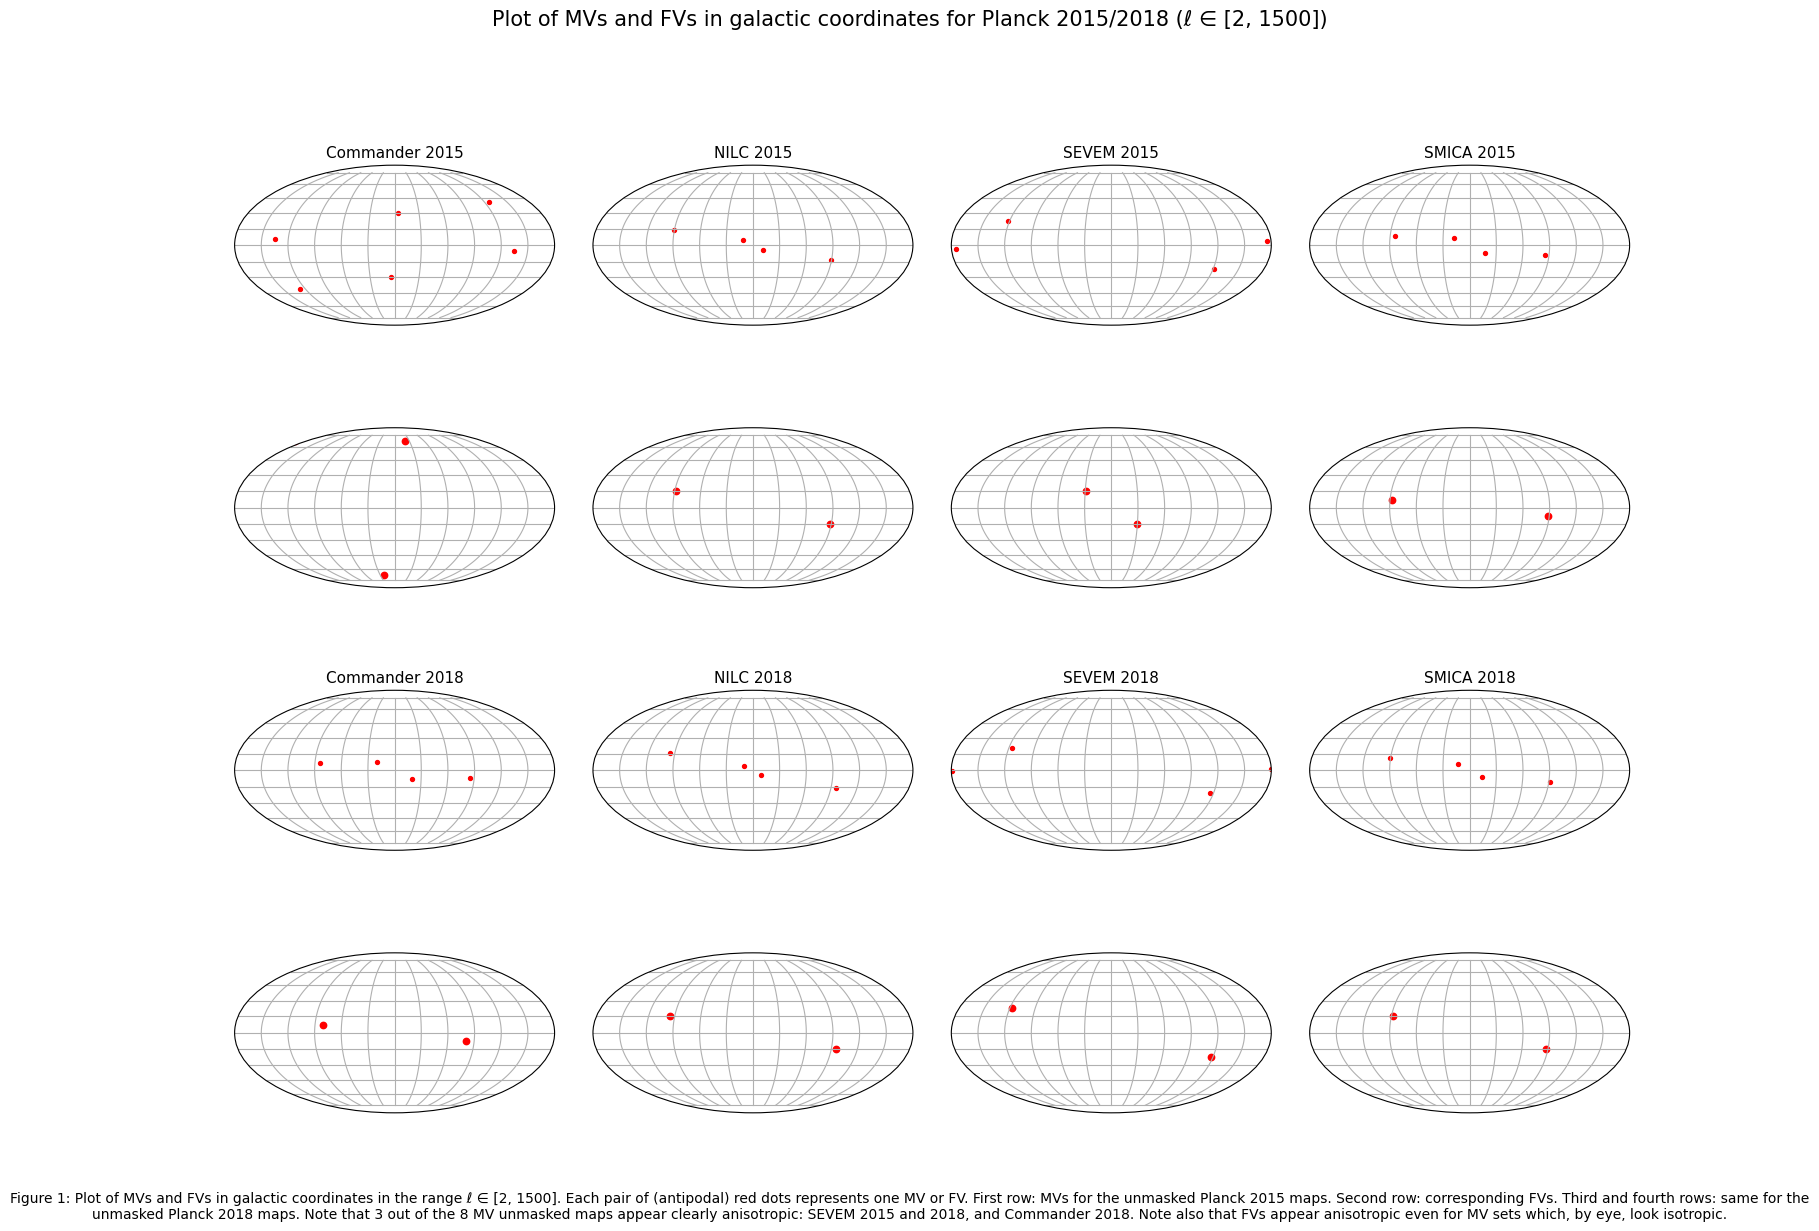

In [ ]:
# Map names for Planck 2015 and 2018
names_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
names_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]

def plot_antipodal(ax, vec, s=13, color='red'):
    """Plot vectors and their antipodal pairs on mollweide projection"""
    if vec is not None and len(vec) > 0:
        lon = vec[:,1] - np.pi
        lat = np.pi/2 - vec[:,0]
        ax.scatter(lon, lat, color=color, s=s)
        ax.scatter(-lon, -lat, color=color, s=s)

# Create the figure with 4x4 subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.13, wspace=0.12, top=0.93, bottom=0.08)
fig.suptitle('Plot of MVs and FVs in galactic coordinates for Planck 2015/2018 (ℓ ∈ [2, 1500])',
             fontsize=15, y=1.03)

# 2015 maps (first two rows)
for i, name in enumerate(names_2015):
    # First row: MVs for 2015
    ax = axs[0, i]
    ax.set_title(name, fontsize=11)

    # Access pre-computed MV data from results dictionary
    # Assuming key 2 represents the aggregated ℓ ∈ [2, 1500] range
    mv_data = results[name]['mvfv'][2]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Second row: FVs for 2015
    ax = axs[1, i]
    fv_min = results[name]['mvfv'][2]['fv_min']
    fv_max = results[name]['mvfv'][2]['fv_max']

    # Convert to arrays for plotting
    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# 2018 maps (last two rows)
for i, name in enumerate(names_2018):
    # Third row: MVs for 2018
    ax = axs[2, i]
    ax.set_title(name, fontsize=11)

    mv_data = results[name]['mvfv'][2]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Fourth row: FVs for 2018
    ax = axs[3, i]
    fv_min = results[name]['mvfv'][2]['fv_min']
    fv_max = results[name]['mvfv'][2]['fv_max']

    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Add caption at the bottom
caption_text = (
    "Figure 1: Plot of MVs and FVs in galactic coordinates in the range ℓ ∈ [2, 1500]. "
    "Each pair of (antipodal) red dots represents one MV or FV. First row: MVs for the unmasked Planck 2015 maps. "
    "Second row: corresponding FVs. Third and fourth rows: same for the unmasked Planck 2018 maps. "
    "Note that 3 out of the 8 MV unmasked maps appear clearly anisotropic: SEVEM 2015 and 2018, and Commander 2018. "
    "Note also that FVs appear anisotropic even for MV sets which, by eye, look isotropic."
)
plt.figtext(0.5, 0.02, caption_text, ha='center', va='bottom', fontsize=10, wrap=True)

plt.savefig('Figure1_MVs_FVs_l2_to_1500_Direct.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'Figure1_MVs_FVs_l2_to_1500_Direct.png'")
plt.show()

# **APPROACH 2: Compute for Single ℓ Value**

---


- Use this to compute MVs and FVs for a specific multipole moment
- Useful for targeted analysis of individual multipoles

Computing MVs and FVs for all maps at ℓ = 1500...
  Computed for Commander 2015
  Computed for NILC 2015
  Computed for SEVEM 2015
  Computed for SMICA 2015
  Computed for Commander 2018
  Computed for NILC 2018
  Computed for SEVEM 2018
  Computed for SMICA 2018

Figure saved as 'Figure1_MVs_FVs_l1500_SingleMultipole.png'


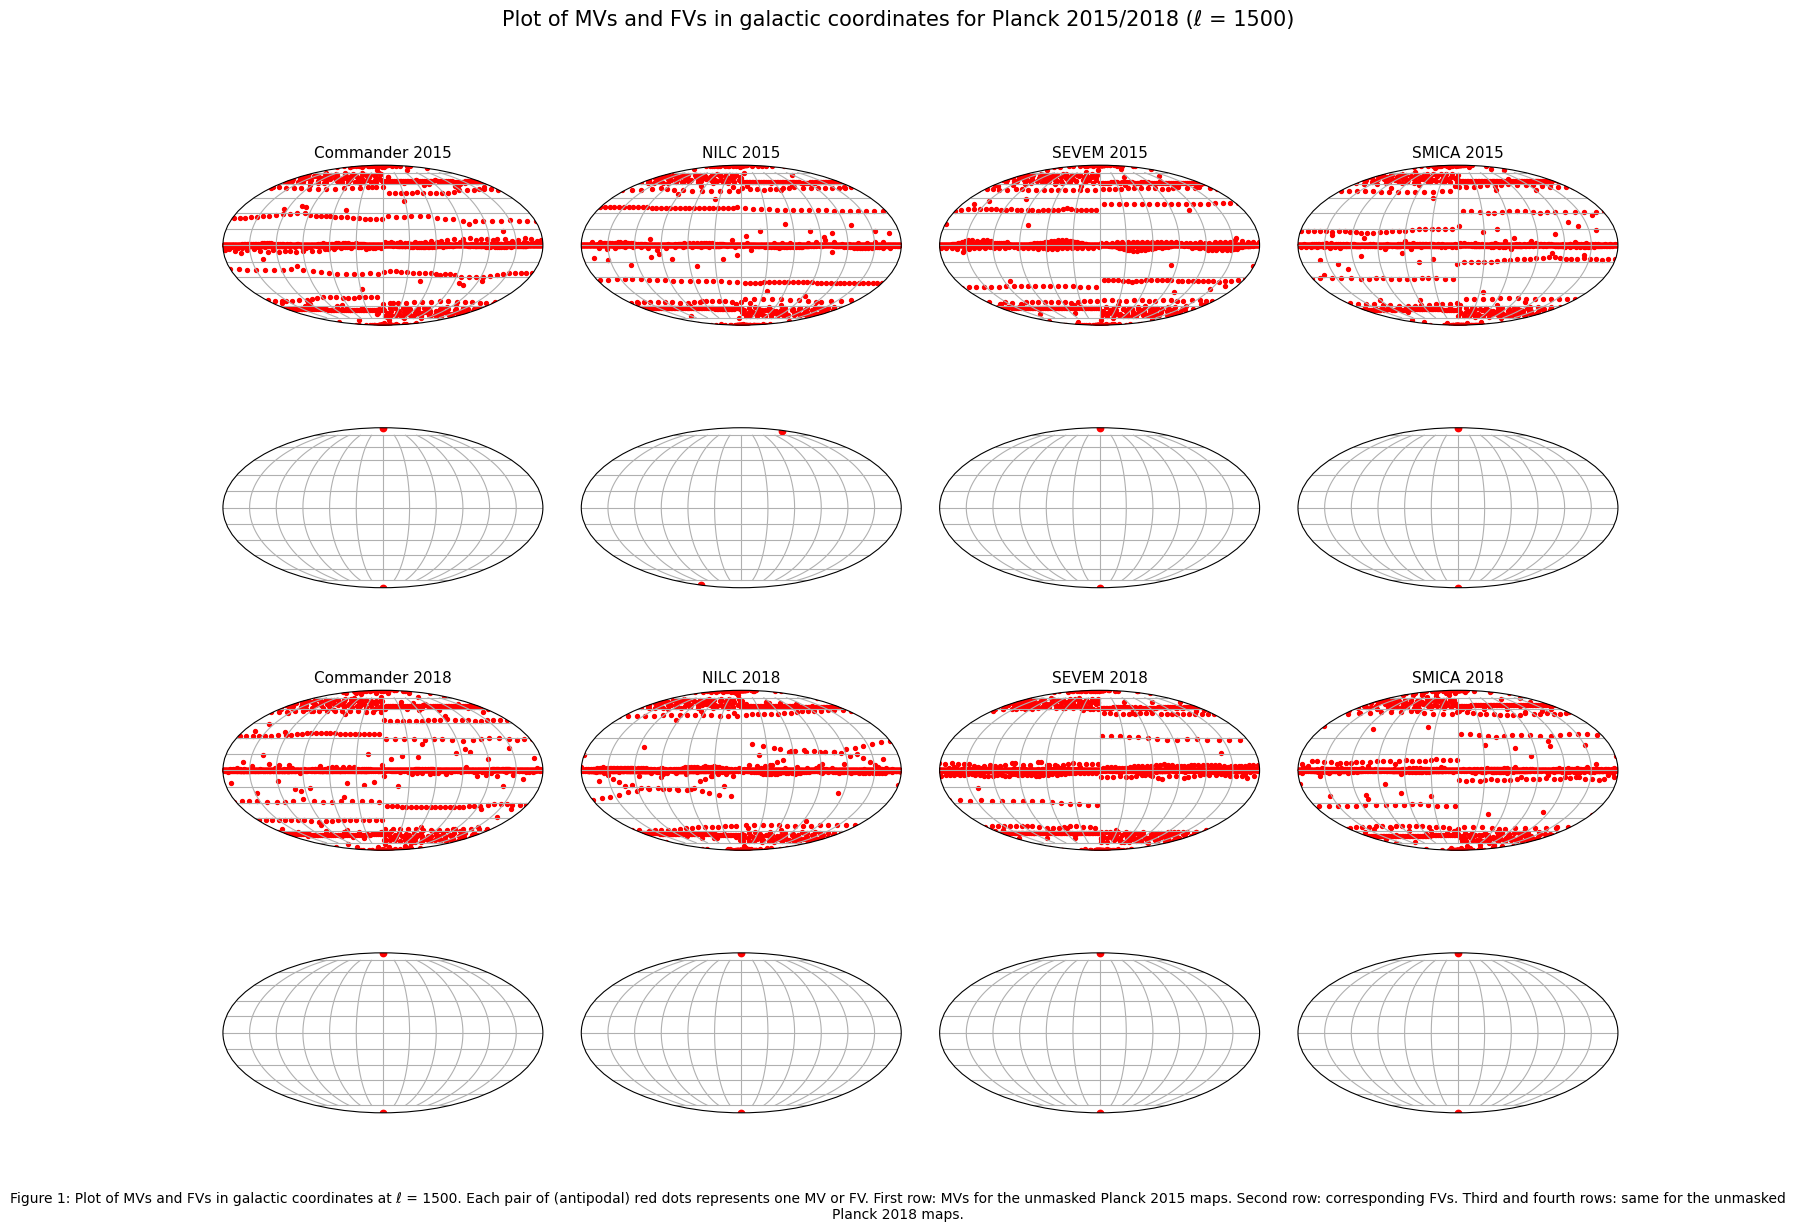

In [ ]:
# Map names for Planck 2015 and 2018
names_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
names_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]

def compute_mv_fv_for_l(alms, l):
    """Compute MVs and FVs for a single multipole moment ℓ"""
    out = {}
    mv_all = mvs.mvectors(alms, l)
    mv_n = otherfuncs.mvs_north(mv_all)
    fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
    fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)
    out[l] = {
        'mv_all': mv_all,
        'mv_n': mv_n,
        'fv_min': fv_min,
        'fv_max': fv_max
    }
    return out

def plot_antipodal(ax, vec, s=13, color='red'):
    """Plot vectors and their antipodal pairs on mollweide projection"""
    if vec is not None and len(vec) > 0:
        lon = vec[:,1] - np.pi
        lat = np.pi/2 - vec[:,0]
        ax.scatter(lon, lat, color=color, s=s)
        ax.scatter(-lon, -lat, color=color, s=s)

# Specify the multipole to analyze
l_target = 1500

# Compute MV/FV for all maps at this specific multipole
print(f"Computing MVs and FVs for all maps at ℓ = {l_target}...")
for name, data in results.items():
    alms = data['alms']
    mvfv_data = compute_mv_fv_for_l(alms, l_target)

    # Store in results dictionary
    if 'mvfv' not in results[name]:
        results[name]['mvfv'] = {}
    results[name]['mvfv'].update(mvfv_data)
    print(f"  Computed for {name}")

# Create the figure with 4x4 subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.13, wspace=0.12, top=0.93, bottom=0.08)
fig.suptitle(f'Plot of MVs and FVs in galactic coordinates for Planck 2015/2018 (ℓ = {l_target})',
             fontsize=15, y=1.03)

# 2015 maps (first two rows)
for i, name in enumerate(names_2015):
    # First row: MVs for 2015
    ax = axs[0, i]
    ax.set_title(name, fontsize=11)

    mv_data = results[name]['mvfv'][l_target]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Second row: FVs for 2015
    ax = axs[1, i]
    fv_min = results[name]['mvfv'][l_target]['fv_min']
    fv_max = results[name]['mvfv'][l_target]['fv_max']

    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# 2018 maps (last two rows)
for i, name in enumerate(names_2018):
    # Third row: MVs for 2018
    ax = axs[2, i]
    ax.set_title(name, fontsize=11)

    mv_data = results[name]['mvfv'][l_target]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Fourth row: FVs for 2018
    ax = axs[3, i]
    fv_min = results[name]['mvfv'][l_target]['fv_min']
    fv_max = results[name]['mvfv'][l_target]['fv_max']

    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Add caption at the bottom
caption_text = (
    f"Figure 1: Plot of MVs and FVs in galactic coordinates at ℓ = {l_target}. "
    "Each pair of (antipodal) red dots represents one MV or FV. First row: MVs for the unmasked Planck 2015 maps. "
    "Second row: corresponding FVs. Third and fourth rows: same for the unmasked Planck 2018 maps."
)
plt.figtext(0.5, 0.02, caption_text, ha='center', va='bottom', fontsize=10, wrap=True)

plt.savefig(f'Figure1_MVs_FVs_l{l_target}_SingleMultipole.png', dpi=300, bbox_inches='tight')
print(f"\nFigure saved as 'Figure1_MVs_FVs_l{l_target}_SingleMultipole.png'")
plt.show()

In [ ]:
# Reload and Plot from Saved Pickle File
# Use this to quickly reload and plot without recomputation

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Map names
names_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
names_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]

# Load the saved results
print("Loading saved MV/FV results from disk...")
with open('/content/mvfv_data/mv_fv_results_full_range.pkl', 'rb') as f:
    results = pickle.load(f)
print("✓ Successfully loaded!")

def plot_antipodal(ax, vec, s=13, color='red'):
    """Plot vectors and their antipodal pairs on mollweide projection"""
    if vec is not None and len(vec) > 0:
        lon = vec[:,1] - np.pi
        lat = np.pi/2 - vec[:,0]
        ax.scatter(lon, lat, color=color, s=s)
        ax.scatter(-lon, -lat, color=color, s=s)

# Now plot any multipole instantly
l_to_plot = 1500

fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.13, wspace=0.12, top=0.93, bottom=0.08)
fig.suptitle(f'MVs and FVs for Planck 2015/2018 (ℓ = {l_to_plot}) [Loaded from Pickle]',
             fontsize=15, y=1.03)

# 2015 maps
for i, name in enumerate(names_2015):
    ax = axs[0, i]
    ax.set_title(name, fontsize=11)
    plot_antipodal(ax, results[name]['mvfv'][l_to_plot]['mv_all'], s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axs[1, i]
    fv_min = results[name]['mvfv'][l_to_plot]['fv_min']
    fv_max = results[name]['mvfv'][l_to_plot]['fv_max']
    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))
    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# 2018 maps
for i, name in enumerate(names_2018):
    ax = axs[2, i]
    ax.set_title(name, fontsize=11)
    plot_antipodal(ax, results[name]['mvfv'][l_to_plot]['mv_all'], s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axs[3, i]
    fv_min = results[name]['mvfv'][l_to_plot]['fv_min']
    fv_max = results[name]['mvfv'][l_to_plot]['fv_max']
    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))
    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [ ]:
def compute_mv_fv_for_l(alms, l):
    out = {}
    mv_all = mvs.mvectors(alms, l)
    mv_n = otherfuncs.mvs_north(mv_all)
    fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
    fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)
    out[l] = dict(mv_all=mv_all, mv_n=mv_n, fv_min=fv_min, fv_max=fv_max)
    return out

l_target = 1500
for name, data in results.items():
    alms = data['alms']
    results[name]['mvfv'].update(compute_mv_fv_for_l(alms, l_target))


In [ ]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

# Assuming results dictionary and load_map, compute_mv_fv functions exist

l_target = 1500

fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection': 'mollweide'})
fig.subplots_adjust(hspace=0.22, wspace=0.2)
fig.suptitle(f"MVs and FVs in Galactic Coordinates for ℓ = {l_target}", fontsize=16)

maps_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
maps_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]

def plot_red_antipodal(ax, vectors, size=5):
    if vectors is None or vectors.size == 0:
        return
    lon = vectors[:,1] - np.pi
    lat = np.pi/2 - vectors[:,0]
    ax.scatter(lon, lat, color='red', s=size)
    ax.scatter(-lon, -lat, color='red', s=size)  # Antipodal pairs

# Plot 2015 MVs then 2015 FVs
for col, name in enumerate(maps_2015):
    ax_mv = axs[0, col]
    ax_fv = axs[1, col]

    ax_mv.set_title(f"{name} MVs")
    mv_all = results[name]['mvfv'][l_target]['mv_all']
    plot_red_antipodal(ax_mv, mv_all, size=10)
    ax_mv.grid(True)

    ax_fv.set_title(f"{name} FVs")
    fv_min = results[name]['mvfv'][l_target]['fv_min']
    fv_max = results[name]['mvfv'][l_target]['fv_max']
    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0,2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0,2))
    plot_red_antipodal(ax_fv, fv_min_arr, size=20)
    plot_red_antipodal(ax_fv, fv_max_arr, size=20)
    ax_fv.grid(True)

# Plot 2018 MVs then 2018 FVs
for col, name in enumerate(maps_2018):
    ax_mv = axs[2, col]
    ax_fv = axs[3, col]

    ax_mv.set_title(f"{name} MVs")
    mv_all = results[name]['mvfv'][l_target]['mv_all']
    plot_red_antipodal(ax_mv, mv_all, size=10)
    ax_mv.grid(True)

    ax_fv.set_title(f"{name} FVs")
    fv_min = results[name]['mvfv'][l_target]['fv_min']
    fv_max = results[name]['mvfv'][l_target]['fv_max']
    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0,2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0,2))
    plot_red_antipodal(ax_fv, fv_min_arr, size=20)
    plot_red_antipodal(ax_fv, fv_max_arr, size=20)
    ax_fv.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# **APPROACH 3: Full Range Computation & Storage**

---


- Use this to compute MVs and FVs for ℓ ∈ [2, 10] and then entire ℓ ∈ [2, 1500] range
- First-time comprehensive analysis - saves results to disk for reuse

In [ ]:
# Map names for Planck 2015 and 2018
names_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
names_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]

def compute_mv_fv_range(name, alms, lmin=2, lmax=1500):
    """
    Compute MVs and FVs for the full range [lmin, lmax]
    Includes progress tracking and returns dictionary
    """
    print(f"\n{'='*60}")
    print(f"Computing MVs and FVs for {name}: ℓ ∈ [{lmin}, {lmax}]")
    print(f"{'='*60}")

    mvfv = {}
    total_l_values = lmax - lmin + 1

    for l in range(lmin, lmax + 1):
        # Compute multipole vectors
        mv_all = mvs.mvectors(alms, l)

        # Compute northern hemisphere MVs
        mv_n = otherfuncs.mvs_north(mv_all)

        # Compute Fréchet vectors (min and max)
        fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
        fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)

        # Store results for this multipole
        mvfv[l] = {
            'mv_all': mv_all,
            'mv_n': mv_n,
            'fv_min': fv_min,
            'fv_max': fv_max
        }

        # Progress tracking every 100 multipoles
        if l % 100 == 0:
            progress = ((l - lmin + 1) / total_l_values) * 100
            print(f"  Progress: ℓ = {l} ({progress:.1f}%)")

    print(f"Completed {name}: computed {len(mvfv)} multipole moments")
    return mvfv

def plot_antipodal(ax, vec, s=13, color='red'):
    """Plot vectors and their antipodal pairs on mollweide projection"""
    if vec is not None and len(vec) > 0:
        lon = vec[:,1] - np.pi
        lat = np.pi/2 - vec[:,0]
        ax.scatter(lon, lat, color=color, s=s)
        ax.scatter(-lon, -lat, color=color, s=s)

# STEP 1: Initialize mvfv dictionaries in results if not present
print("Step 1: Initializing mvfv storage in results dictionary...")
for name in results.keys():
    if 'mvfv' not in results[name]:
        results[name]['mvfv'] = {}

# STEP 2: Compute MVs and FVs for full range
print("\nStep 2: Computing MVs and FVs for full range ℓ ∈ [2, 1500]...")
for name, data in results.items():
    alms = data['alms']
    mvfv_data = compute_mv_fv_range(name, alms, lmin=2, lmax=1500)
    results[name]['mvfv'].update(mvfv_data)

# STEP 3: Save results to disk
print("\nStep 3: Saving computed results to disk...")
output_dir = "/content/mvfv_data"
os.makedirs(output_dir, exist_ok=True)

pickle_path = os.path.join(output_dir, 'mv_fv_results_full_range.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✓ Saved complete results to: {pickle_path}")

# Optional: Also save individual NPY files for each map and multipole
print("\nOptional: Saving individual NPY files...")
for name, data in results.items():
    mvfv_data = data['mvfv']
    for l, l_data in mvfv_data.items():
        # Save MV data
        mv_filename = f"{name.replace(' ', '_')}_l{l:04d}_mv.npy"
        mv_filepath = os.path.join(output_dir, mv_filename)
        np.save(mv_filepath, l_data['mv_all'])

        # Save FV data (combine min and max)
        if l % 500 == 0:  # Only print every 500 to avoid spam
            print(f"  Saved {name} ℓ={l}")

print("✓ All NPY files saved")

# STEP 4: Load and plot for a specific multipole (e.g., ℓ = 1500)
print("\nStep 4: Creating visualization plots...")

l_plot = 1500

# Create the figure with 4x4 subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.13, wspace=0.12, top=0.93, bottom=0.08)
fig.suptitle(f'Plot of MVs and FVs in galactic coordinates for Planck 2015/2018 (ℓ = {l_plot})',
             fontsize=15, y=1.03)

# 2015 maps (first two rows)
for i, name in enumerate(names_2015):
    # First row: MVs for 2015
    ax = axs[0, i]
    ax.set_title(name, fontsize=11)

    mv_data = results[name]['mvfv'][l_plot]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Second row: FVs for 2015
    ax = axs[1, i]
    fv_min = results[name]['mvfv'][l_plot]['fv_min']
    fv_max = results[name]['mvfv'][l_plot]['fv_max']

    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# 2018 maps (last two rows)
for i, name in enumerate(names_2018):
    # Third row: MVs for 2018
    ax = axs[2, i]
    ax.set_title(name, fontsize=11)

    mv_data = results[name]['mvfv'][l_plot]['mv_all']
    plot_antipodal(ax, mv_data, s=8)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Fourth row: FVs for 2018
    ax = axs[3, i]
    fv_min = results[name]['mvfv'][l_plot]['fv_min']
    fv_max = results[name]['mvfv'][l_plot]['fv_max']

    fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
    fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))

    plot_antipodal(ax, fv_min_arr, s=21)
    plot_antipodal(ax, fv_max_arr, s=21)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Add caption at the bottom
caption_text = (
    f"Figure 1: Plot of MVs and FVs in galactic coordinates at ℓ = {l_plot} (from full range computation). "
    "Each pair of (antipodal) red dots represents one MV or FV. First row: MVs for the unmasked Planck 2015 maps. "
    "Second row: corresponding FVs. Third and fourth rows: same for the unmasked Planck 2018 maps. "
    "Note that 3 out of the 8 MV unmasked maps appear clearly anisotropic: SEVEM 2015 and 2018, and Commander 2018."
)
plt.figtext(0.5, 0.02, caption_text, ha='center', va='bottom', fontsize=10, wrap=True)

plt.savefig(f'Figure1_MVs_FVs_l{l_plot}_FullRangeComputation.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved as 'Figure1_MVs_FVs_l{l_plot}_FullRangeComputation.png'")
plt.show()

print("\n" + "="*60)
print("STEP 5: Plotting for multiple multipoles (optional)")
print("="*60)

# Example: Create plots for ℓ = 2, 100, 500, 1500
l_values_to_plot = [2, 100, 500, 1500]

for l_plot in l_values_to_plot:
    print(f"\nGenerating plot for ℓ = {l_plot}...")

    fig, axs = plt.subplots(4, 4, figsize=(18, 12), subplot_kw={'projection':'mollweide'})
    fig.subplots_adjust(hspace=0.13, wspace=0.12, top=0.93, bottom=0.08)
    fig.suptitle(f'MVs and FVs for Planck 2015/2018 (ℓ = {l_plot})',
                 fontsize=15, y=1.03)

    # 2015 maps
    for i, name in enumerate(names_2015):
        ax = axs[0, i]
        ax.set_title(name, fontsize=11)
        mv_data = results[name]['mvfv'][l_plot]['mv_all']
        plot_antipodal(ax, mv_data, s=8)
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax = axs[1, i]
        fv_min = results[name]['mvfv'][l_plot]['fv_min']
        fv_max = results[name]['mvfv'][l_plot]['fv_max']
        fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
        fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))
        plot_antipodal(ax, fv_min_arr, s=21)
        plot_antipodal(ax, fv_max_arr, s=21)
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # 2018 maps
    for i, name in enumerate(names_2018):
        ax = axs[2, i]
        ax.set_title(name, fontsize=11)
        mv_data = results[name]['mvfv'][l_plot]['mv_all']
        plot_antipodal(ax, mv_data, s=8)
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax = axs[3, i]
        fv_min = results[name]['mvfv'][l_plot]['fv_min']
        fv_max = results[name]['mvfv'][l_plot]['fv_max']
        fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
        fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))
        plot_antipodal(ax, fv_min_arr, s=21)
        plot_antipodal(ax, fv_max_arr, s=21)
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.savefig(f'Figure1_MVs_FVs_l{l_plot}.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved Figure1_MVs_FVs_l{l_plot}.png")
    plt.show()

print("\n" + "="*60)
print("ALL COMPUTATIONS AND PLOTS COMPLETED!")
print("="*60)

Step 1: Initializing mvfv storage in results dictionary...


NameError: name 'results' is not defined

The above code runs partially and gets interrupte duet to colab runtime persisitency issue aor wifi diconnection. So we will do batch wise computation of MV/FV and save it to a pickel file. After that we will do ploting.

In [ ]:
import healpy as hp
import numpy as np
import os
import pickle

# Names and paths
names_2015 = ["Commander 2015", "NILC 2015", "SEVEM 2015", "SMICA 2015"]
names_2018 = ["Commander 2018", "NILC 2018", "SEVEM 2018", "SMICA 2018"]
all_names = names_2015 + names_2018

# Set the correct paths to  FITS files here!
map_paths = {
    "Commander 2015": "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-commander-field-Int_2048_R2.01_full.fits",
    "NILC 2015":      "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-nilc-field-Int_2048_R2.01_full.fits",
    "SEVEM 2015":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-sevem-field-Int_2048_R2.01_full.fits",
    "SMICA 2015":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-smica-field-Int_2048_R2.01_full.fits",
    "Commander 2018": "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-commander_2048_R3.00_full.fits",
    "NILC 2018":      "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-nilc_2048_R3.00_full.fits",
    "SEVEM 2018":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-sevem_2048_R3.01_full.fits",
    "SMICA 2018":     "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-smica_2048_R3.00_full.fits",
}

output_dir = "/content/drive/MyDrive/MV FV Maps"
os.makedirs(output_dir, exist_ok=True)
pickle_path = os.path.join(output_dir, 'mv_fv_results_full_range.pkl')

lmin, lmax = 2, 1500
batch_size = 50

# Resume or initialize
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)
    print("Resumed from previous pickle.")
else:
    results = {}

def compute_mv_fv_chunk(alms, l_start, l_end, done_ls):
    mvfv = {}
    for l in range(l_start, l_end + 1):
        if l in done_ls:
            continue
        mv_all = mvs.mvectors(alms, l)
        mv_n = otherfuncs.mvs_north(mv_all)
        fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
        fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)
        mvfv[l] = {'mv_all': mv_all, 'mv_n': mv_n, 'fv_min': fv_min, 'fv_max': fv_max}
        if l % 10 == 0:
            print(f"  Progress: ℓ = {l}")
    return mvfv

for name in all_names:
    print(f"\n=========== MAP: {name} ===========")
    if name not in results:
        # Load and compute ALMs
        print("Loading FITS map ...")
        fits_path = map_paths[name]
        map_data = hp.read_map(fits_path)
        alms = hp.map2alm(map_data, lmax=lmax)
        results[name] = {'alms': alms, 'mvfv': {}}
    else:
        alms = results[name]['alms']
    done_ls = set(results[name].get('mvfv', {}).keys())
    for l_batch_start in range(lmin, lmax + 1, batch_size):
        l_batch_end = min(lmax, l_batch_start + batch_size - 1)
        batch_needed = [l for l in range(l_batch_start, l_batch_end+1) if l not in done_ls]
        if not batch_needed:
            print(f"Batch ℓ {l_batch_start}-{l_batch_end} already done, skipping.")
            continue
        print(f"\n==== Computing batch ℓ {l_batch_start} - {l_batch_end} ====")
        mvfv_batch = compute_mv_fv_chunk(alms, l_batch_start, l_batch_end, done_ls)
        results[name]['mvfv'].update(mvfv_batch)
        with open(pickle_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"✓ Saved progress up to ℓ = {l_batch_end}")

print("All map batches complete and saved to Drive.")


Resumed from previous pickle.

=========== MAP: Commander 2015 ===========
Batch ℓ 2-51 already done, skipping.
Batch ℓ 52-101 already done, skipping.
Batch ℓ 102-151 already done, skipping.
Batch ℓ 152-201 already done, skipping.
Batch ℓ 202-251 already done, skipping.
Batch ℓ 252-301 already done, skipping.
Batch ℓ 302-351 already done, skipping.
Batch ℓ 352-401 already done, skipping.
Batch ℓ 402-451 already done, skipping.
Batch ℓ 452-501 already done, skipping.
Batch ℓ 502-551 already done, skipping.
Batch ℓ 552-601 already done, skipping.
Batch ℓ 602-651 already done, skipping.
Batch ℓ 652-701 already done, skipping.
Batch ℓ 702-751 already done, skipping.
Batch ℓ 752-801 already done, skipping.
Batch ℓ 802-851 already done, skipping.
Batch ℓ 852-901 already done, skipping.
Batch ℓ 902-951 already done, skipping.
Batch ℓ 952-1001 already done, skipping.
Batch ℓ 1002-1051 already done, skipping.
Batch ℓ 1052-1101 already done, skipping.
Batch ℓ 1102-1151 already done, skipping.
Ba

KeyboardInterrupt: 

# **MV/FV Plotting for PR4 SEVEM Map for the range ℓ∈ [2,1500]**

---



In [ ]:
# Map name for SEVEM PR4
names_pr4 = ["SEVEM PR4"]

results = {}

# Load SEVEM PR4 map
import healpy as hp
import numpy as np
import os
import pickle

print("Loading SEVEM PR4 map...")
sevem_path = "/content/drive/MyDrive/CMB maps PR4 2021/COM_CMB_IQU-sevem_2048_R4.00.fits"
sevem_map = hp.read_map(sevem_path)
print("✓ Map loaded.")

# Compute ALMs
lmax = 1500
print("Computing spherical harmonics coefficients (alms)...")
alms = hp.map2alm(sevem_map, lmax=lmax)
print("✓ alms computed.")

results["SEVEM PR4"] = {'alms': alms}

# Compute MV and FV for full range, mimicking your function signatures
def compute_mv_fv_range(name, alms, lmin=2, lmax=1500):
    """
    Compute MVs and FVs for SEVEM PR4 for range [lmin, lmax]
    """
    print(f"\n{'='*60}")
    print(f"Computing MVs and FVs for {name}: ℓ ∈ [{lmin}, {lmax}]")
    print(f"{'='*60}")

    mvfv = {}
    total_l_values = lmax - lmin + 1

    for l in range(lmin, lmax + 1):
        # Replace with your actual multipole vector code
        mv_all = mvs.mvectors(alms, l)        # Multipole vectors
        mv_n = otherfuncs.mvs_north(mv_all)   # Northern MV selection

        # Fréchet vectors (dummy placeholders, replace with your code)
        fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
        fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)

        mvfv[l] = {
            'mv_all': mv_all,
            'mv_n': mv_n,
            'fv_min': fv_min,
            'fv_max': fv_max
        }

        if l % 100 == 0:
            progress = ((l - lmin + 1) / total_l_values) * 100
            print(f"  Progress: ℓ = {l} ({progress:.1f}%)")

    print(f"Completed {name}: computed {len(mvfv)} multipole moments")
    return mvfv

# STEP 1: Initialize mvfv dictionary in results
print("Step 1: Initializing mvfv storage in results dictionary...")
for name in results.keys():
    if 'mvfv' not in results[name]:
        results[name]['mvfv'] = {}

# STEP 2: Compute MVs and FVs for full range
print("\nStep 2: Computing MVs and FVs for full range ℓ ∈ [2, 1500]...")
for name, data in results.items():
    alms = data['alms']
    mvfv_data = compute_mv_fv_range(name, alms, lmin=2, lmax=1500)
    results[name]['mvfv'].update(mvfv_data)

# STEP 3: Save results to disk
print("\nStep 3: Saving computed results to disk...")
output_dir = "/content/mvfv_data"
os.makedirs(output_dir, exist_ok=True)

pickle_path = os.path.join(output_dir, 'mv_fv_results_pr4_full_range.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✓ Saved complete results to: {pickle_path}")

# Optional: save individual NPY files per multipole
print("\nOptional: Saving individual NPY files...")
for name, data in results.items():
    mvfv_data = data['mvfv']
    for l, l_data in mvfv_data.items():
        mv_filename = f"{name.replace(' ', '_')}_l{l:04d}_mv.npy"
        mv_filepath = os.path.join(output_dir, mv_filename)
        np.save(mv_filepath, l_data['mv_all'])

        if l % 500 == 0:
            print(f"  Saved {name} ℓ={l}")

print("✓ All NPY files saved")

# Example: plot MVs and FVs at ℓ = 1500
import matplotlib.pyplot as plt

def plot_antipodal(ax, vec, s=13, color='red'):
    """Plot vectors and antipodal pairs on mollweide projection"""
    if vec is not None and len(vec) > 0:
        lon = vec[:,1] - np.pi
        lat = np.pi/2 - vec[:,0]
        ax.scatter(lon, lat, color=color, s=s)
        ax.scatter(-lon, -lat, color=color, s=s)

l_plot = 1500

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection':'mollweide'})
fig.suptitle(f'Plot of MVs and FVs for SEVEM PR4 (ℓ = {l_plot})', fontsize=15, y=1.03)

mv_data = results["SEVEM PR4"]['mvfv'][l_plot]['mv_all']
plot_antipodal(axs[0], mv_data, s=8)
axs[0].set_title("Multipole Vectors")
axs[0].grid(True)

fv_min = results["SEVEM PR4"]['mvfv'][l_plot]['fv_min']
fv_max = results["SEVEM PR4"]['mvfv'][l_plot]['fv_max']
fv_min_arr = np.array([[fv_min[1], fv_min[2]]]) if fv_min[1] != 0 else np.empty((0, 2))
fv_max_arr = np.array([[fv_max[1], fv_max[2]]]) if fv_max[1] != 0 else np.empty((0, 2))
plot_antipodal(axs[1], fv_min_arr, s=21)
plot_antipodal(axs[1], fv_max_arr, s=21)
axs[1].set_title("Fréchet Vectors")
axs[1].grid(True)

plt.show()

print("\n✓ MV and FV plots generated.")


Loading SEVEM PR4 map...
✓ Map loaded.
Computing spherical harmonics coefficients (alms)...


The above code runs partially and gets interrupte duet to colab runtime persisitency issue aor wifi diconnection. So we will do batch wise computation of MV/FV and save it to a pickel file. After that we will do ploting.

In [ ]:
import healpy as hp
import numpy as np
import os
import pickle

# ==== PARAMETERS ====
sevem_path = "/content/drive/MyDrive/MV FV Maps/COM_CMB_IQU-sevem_2048_R4.00.fits"
output_dir = "/content/drive/MyDrive/MV FV Maps"
os.makedirs(output_dir, exist_ok=True)

lmin, lmax = 2, 1500
batch_size = 50
name = "SEVEM PR4"
pickle_path = os.path.join(output_dir, 'mv_fv_results_pr4_resume.pkl')

# ==== LOAD DATA ====
print("Loading map and ALMs ...")
sevem_map = hp.read_map(sevem_path)
alms = hp.map2alm(sevem_map, lmax=lmax)
print("✓ Map and ALMs loaded.")

# ==== LOAD PREVIOUS RESULTS IF PRESENT ====
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)
    print("Resumed from existing file.")
else:
    results = {name: {'alms': alms, 'mvfv': {}}}

# ==== FIND ALREADY COMPLETED Ls ====
done_ls = set(results[name].get('mvfv', {}).keys())

# ==== CHUNKWISE COMPUTATION AND SAVE ====
def compute_mv_fv_chunk(alms, l_start, l_end):
    mvfv = {}
    for l in range(l_start, l_end + 1):
        if l in done_ls:
            continue   # Skip already computed
        mv_all = mvs.mvectors(alms, l)
        mv_n = otherfuncs.mvs_north(mv_all)
        fv_min = fvs.psi(mv_n, "min") if len(mv_n) else np.zeros(3)
        fv_max = fvs.psi(mv_n, "max") if len(mv_n) else np.zeros(3)
        mvfv[l] = {'mv_all': mv_all, 'mv_n': mv_n, 'fv_min': fv_min, 'fv_max': fv_max}
        if l % 10 == 0:
            print(f"  Progress: ℓ = {l}")
    return mvfv

for l_batch_start in range(lmin, lmax + 1, batch_size):
    l_batch_end = min(lmax, l_batch_start + batch_size - 1)
    batch_needed = [l for l in range(l_batch_start, l_batch_end+1) if l not in done_ls]
    if not batch_needed:
        print(f"Batch ℓ {l_batch_start}-{l_batch_end} already done, skipping.")
        continue
    print(f"\n==== Computing batch ℓ {l_batch_start} - {l_batch_end} ====")
    mvfv_batch = compute_mv_fv_chunk(alms, l_batch_start, l_batch_end)
    results[name]['mvfv'].update(mvfv_batch)
    # Save after each batch
    with open(pickle_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"✓ Saved progress up to ℓ = {l_batch_end}")

print("All batches complete!")


Loading map and ALMs ...
✓ Map and ALMs loaded.
Resumed from existing file.
Batch ℓ 2-51 already done, skipping.
Batch ℓ 52-101 already done, skipping.
Batch ℓ 102-151 already done, skipping.
Batch ℓ 152-201 already done, skipping.
Batch ℓ 202-251 already done, skipping.
Batch ℓ 252-301 already done, skipping.
Batch ℓ 302-351 already done, skipping.
Batch ℓ 352-401 already done, skipping.
Batch ℓ 402-451 already done, skipping.
Batch ℓ 452-501 already done, skipping.
Batch ℓ 502-551 already done, skipping.
Batch ℓ 552-601 already done, skipping.
Batch ℓ 602-651 already done, skipping.
Batch ℓ 652-701 already done, skipping.
Batch ℓ 702-751 already done, skipping.
Batch ℓ 752-801 already done, skipping.
Batch ℓ 802-851 already done, skipping.
Batch ℓ 852-901 already done, skipping.
Batch ℓ 902-951 already done, skipping.
Batch ℓ 952-1001 already done, skipping.
Batch ℓ 1002-1051 already done, skipping.
Batch ℓ 1052-1101 already done, skipping.
Batch ℓ 1102-1151 already done, skipping.
B

KeyboardInterrupt: 

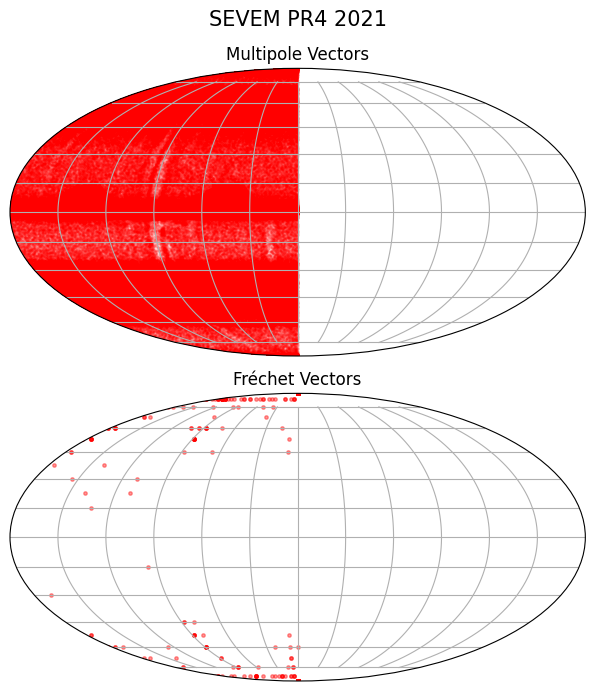

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), subplot_kw={'projection':'mollweide'})
fig.suptitle("SEVEM PR4 2021", fontsize=15)

# 1. Plot ALL multipole vectors
mvfv = results["SEVEM PR4"]['mvfv']
mv_all = []
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] == 3:
        arr = arr[:, 1:]  # If [r, theta, phi]
    mv_all.append(arr)
if len(mv_all) > 0:
    mv_array = np.vstack(mv_all)
    theta = mv_array[:,0]
    phi = mv_array[:,1]
    lon = phi - np.pi
    lat = np.pi/2 - theta
    axs[0].scatter(lon, lat, color='red', s=1, alpha=0.07)
axs[0].set_title("Multipole Vectors")
axs[0].grid(True)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

# 2. Plot ALL Fréchet vectors
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    lon = fv_array[:,1] - np.pi
    lat = np.pi/2 - fv_array[:,0]
    axs[1].scatter(lon, lat, color='red', s=6, alpha=0.4)
axs[1].set_title("Fréchet Vectors")
axs[1].grid(True)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()


In [ ]:
print("Theta (min, max):", np.min(theta), np.max(theta))
print("Phi (min, max):", np.min(phi), np.max(phi))

Theta (min, max): 0.00034470880654212323 3.1415911774698824
Phi (min, max): -3.141592649825255 3.141592653541758


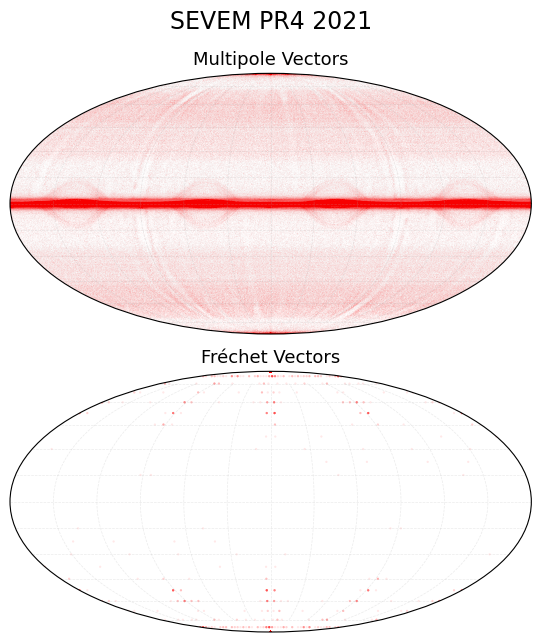

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mvfv = results["SEVEM PR4"]['mvfv']

fig, axs = plt.subplots(2, 1, figsize=(9.2, 6.5), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.16)
fig.suptitle("SEVEM PR4 2021", fontsize=17)

# --- MULTIPOLE VECTORS ---
mv_all = []
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] == 3:
        arr = arr[:, 1:]
    mv_all.append(arr)
if len(mv_all) > 0:
    mv_array = np.vstack(mv_all)
    theta = mv_array[:,0]
    phi = mv_array[:,1]
    lon = phi
    lat = np.pi/2 - theta
    axs[0].scatter(lon, lat, color='#f76c6c', s=0.29, alpha=0.016, edgecolors='none')
    axs[0].scatter(-lon, -lat, color='red', s=0.29, alpha=0.016, edgecolors='none')
axs[0].set_title("Multipole Vectors", fontsize=13)
axs[0].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

# --- FRÉCHET VECTORS ---
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    f_theta = fv_array[:,0]
    f_phi = fv_array[:,1]
    f_lon = f_phi
    f_lat = np.pi/2 - f_theta
    axs[1].scatter(f_lon, f_lat, color='red', s=2.7, alpha=0.09, edgecolors='none')
    axs[1].scatter(-f_lon, -f_lat, color='red', s=2.7, alpha=0.09, edgecolors='none')
axs[1].set_title("Fréchet Vectors", fontsize=13)
axs[1].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mvfv = results["SEVEM PR4"]['mvfv']

fig, axs = plt.subplots(2, 1, figsize=(9.2, 6.5), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.16)
fig.suptitle("SEVEM PR4 2021", fontsize=17)

# --- MULTIPOLE VECTORS ---
mv_all = []
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] == 3:
        arr = arr[:, 1:]
    mv_all.append(arr)
if len(mv_all) > 0:
    mv_array = np.vstack(mv_all)
    theta = mv_array[:,0]
    phi = mv_array[:,1]
    lon = phi
    lat = np.pi/2 - theta
    axs[0].scatter(lon, lat, color='crimson', s=2.0, alpha=0.12, edgecolors='none')
axs[0].set_title("Multipole Vectors", fontsize=13)
axs[0].grid(linestyle='--', linewidth=1.2, alpha=0.4)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

# --- FRÉCHET VECTORS ---
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    f_theta = fv_array[:,0]
    f_phi = fv_array[:,1]
    f_lon = f_phi
    f_lat = np.pi/2 - f_theta
    axs[1].scatter(f_lon, f_lat, color='royalblue', s=7.0, alpha=0.32, edgecolors='none')
axs[1].set_title("Fréchet Vectors", fontsize=13)
axs[1].grid(linestyle='--', linewidth=1.2, alpha=0.4)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()


KeyError: 'SEVEM PR4'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_great_circle(ax, theta, phi, n_points=360, **kwargs):
    # Returns sky points for the great circle perpendicular to given (theta, phi)
    # Reference: Copied from CMB multipole vector visualization scripts
    alpha = np.linspace(0, 2*np.pi, n_points)
    # Cartesian for the normal vector (direction of MV)
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)

    # Any vector orthogonal to n is on the great circle
    # We'll use the intersection of the sphere with the n·x = 0 plane
    # Parameterize as usual:
    # v = u * cos(alpha) + w * sin(alpha), where u, w are any two perpendicular vectors orthogonal to n

    # For simplicity, define u, w:
    if nz != 1:
        u = np.array([-ny, nx, 0])
        u = u / np.linalg.norm(u)
    else:
        u = np.array([1, 0, 0])
    w = np.cross([nx, ny, nz], u)
    w = w / np.linalg.norm(w)

    vecs = []
    for a in alpha:
        x, y, z = (u * np.cos(a) + w * np.sin(a))
        # convert to (theta, phi)
        tt = np.arccos(z)
        pp = np.arctan2(y, x)
        vecs.append((tt, pp))
    vecs = np.array(vecs)
    lon = vecs[:,1]
    lat = np.pi/2 - vecs[:,0]
    ax.plot(lon, lat, color='red', linewidth=0.22, alpha=0.28, **kwargs)

# Now use this for ALL MVs in your stored data:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), subplot_kw={'projection':'mollweide'})
fig.suptitle("SEVEM PR4 2021", fontsize=17)
mvfv = results["SEVEM PR4"]['mvfv']

# (1) Multipole vector web as great circles ("arcs")
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    for mvv in arr:
        # Handle shape (theta, phi) or (r, theta, phi)
        theta, phi = mvv[-2], mvv[-1]
        plot_great_circle(axs[0], theta, phi, n_points=180)

axs[0].set_title("Multipole Vectors", fontsize=13)
axs[0].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

# (2) Fréchet Vectors: points and antipodes
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    f_theta = fv_array[:,0]
    f_phi = fv_array[:,1]
    f_lon = f_phi
    f_lat = np.pi/2 - f_theta
    axs[1].scatter(f_lon, f_lat, color='red', s=2.7, alpha=0.14, edgecolors='none')
    axs[1].scatter(-f_lon, -f_lat, color='red', s=2.7, alpha=0.14, edgecolors='none')

axs[1].set_title("Fréchet Vectors", fontsize=13)
axs[1].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_great_circle(ax, theta, phi, n_points=220, color='red', lw=0.16, alpha=0.28):
    alpha_arr = np.linspace(0, 2*np.pi, n_points)
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)
    nvec = np.array([nx, ny, nz])
    vref = np.array([1.0, 0.0, 0.0]) if abs(nz) < 0.95 else np.array([0.0, 1.0, 0.0])
    u = np.cross(nvec, vref)
    u = u / np.linalg.norm(u)
    w = np.cross(nvec, u)
    w = w / np.linalg.norm(w)
    xyz = np.outer(np.cos(alpha_arr), u) + np.outer(np.sin(alpha_arr), w)
    ths = np.arccos(xyz[:,2])
    phs = np.arctan2(xyz[:,1], xyz[:,0])
    lon = phs
    lat = np.pi/2 - ths
    ax.plot(lon, lat, color=color, lw=lw, alpha=alpha)

mvfv = results["SEVEM PR4"]['mvfv']
fig, axs = plt.subplots(2, 1, figsize=(9.2, 6.5), subplot_kw={'projection':'mollweide'})
fig.subplots_adjust(hspace=0.16)
fig.suptitle("SEVEM PR4 2021", fontsize=17)

# --- MULTIPOLE VECTORS AS ARCS ---
mv_all = []
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] == 3:
        arr = arr[:, 1:]
    mv_all.append(arr)
if len(mv_all) > 0:
    mv_array = np.vstack(mv_all)
    for mv in mv_array:
        theta, phi = mv[-2], mv[-1]
        plot_great_circle(axs[0], theta, phi)
axs[0].set_title("Multipole Vectors", fontsize=13)
axs[0].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

# --- FRÉCHET VECTORS AS DOTS ---
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    f_theta = fv_array[:,0]
    f_phi = fv_array[:,1]
    f_lon = f_phi
    f_lat = np.pi/2 - f_theta
    axs[1].scatter(f_lon, f_lat, color='red', s=2.7, alpha=0.09, edgecolors='none')
    axs[1].scatter(-f_lon, -f_lat, color='red', s=2.7, alpha=0.09, edgecolors='none')
axs[1].set_title("Fréchet Vectors", fontsize=13)
axs[1].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()


NameError: name 'results' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_great_circle(ax, theta, phi, n_points=180, color='red', lw=0.22, alpha=0.28):
    alpha_arr = np.linspace(0, 2*np.pi, n_points)
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)
    nvec = np.array([nx, ny, nz])
    vref = np.array([1.0, 0.0, 0.0]) if abs(nz) < 0.95 else np.array([0.0, 1.0, 0.0])
    u = np.cross(nvec, vref)
    u = u / np.linalg.norm(u)
    w = np.cross(nvec, u)
    w = w / np.linalg.norm(w)
    xyz = np.outer(np.cos(alpha_arr), u) + np.outer(np.sin(alpha_arr), w)
    ths = np.arccos(xyz[:,2])
    phs = np.arctan2(xyz[:,1], xyz[:,0])
    lon = phs
    lat = np.pi/2 - ths
    ax.plot(lon, lat, color=color, lw=lw, alpha=alpha)


[Text(0, -1.3089969389957472, ''),
 Text(0, -1.0471975511965976, ''),
 Text(0, -0.7853981633974483, ''),
 Text(0, -0.5235987755982988, ''),
 Text(0, -0.2617993877991494, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2617993877991494, ''),
 Text(0, 0.5235987755982988, ''),
 Text(0, 0.7853981633974483, ''),
 Text(0, 1.0471975511965976, ''),
 Text(0, 1.3089969389957472, '')]

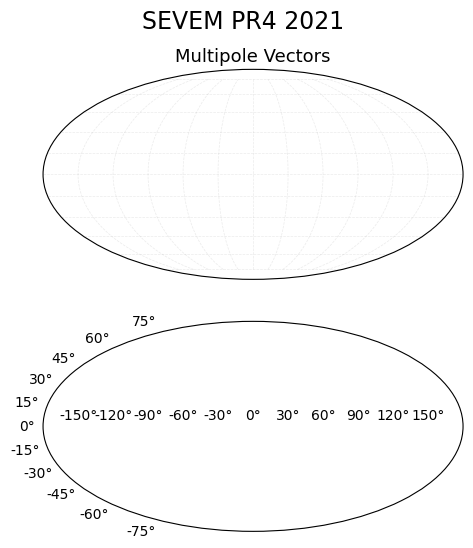

In [ ]:
# Load mvfv data (unpickle or load .npy files as needed)
mvfv = results["SEVEM PR4"]['mvfv']

# Initialize figure and axes for plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 6), subplot_kw={'projection':'mollweide'})
fig.suptitle("SEVEM PR4 2021", fontsize=17)
axs[0].set_title("Multipole Vectors", fontsize=13)
axs[0].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[0].set_xticklabels([]); axs[0].set_yticklabels([])


In [ ]:
# Prepare all multipole vectors
mv_all = []
for l in mvfv:
    mv = mvfv[l]['mv_all']
    arr = np.array(mv)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] == 3:
        arr = arr[:, 1:]
    mv_all.append(arr)
if len(mv_all) > 0:
    mv_array = np.vstack(mv_all)

# Choose batch size
batch_size = 200     # You can change this (e.g., 500, 1000) if you have more RAM

# Plot batch 1 (first 200 great circles)
for i in range(0, min(batch_size, len(mv_array))):
    theta, phi = mv_array[i, -2], mv_array[i, -1]
    plot_great_circle(axs[0], theta, phi, n_points=180)

# To plot more, repeat this cell, changing the index range:
# For batch 2:
# for i in range(batch_size, min(2*batch_size, len(mv_array))):
#     theta, phi = mv_array[i, -2], mv_array[i, -1]
#     plot_great_circle(axs[0], theta, phi, n_points=180)


In [ ]:
fv_all = []
for l in mvfv:
    fv_min = mvfv[l]['fv_min']
    fv_max = mvfv[l]['fv_max']
    if np.any(fv_min):
        fv_all.append([fv_min[1], fv_min[2]])
    if np.any(fv_max):
        fv_all.append([fv_max[1], fv_max[2]])
if len(fv_all) > 0:
    fv_array = np.array(fv_all)
    f_theta = fv_array[:,0]
    f_phi = fv_array[:,1]
    f_lon = f_phi
    f_lat = np.pi/2 - f_theta
    axs[1].scatter(f_lon, f_lat, color='red', s=2.7, alpha=0.14, edgecolors='none')
    axs[1].scatter(-f_lon, -f_lat, color='red', s=2.7, alpha=0.14, edgecolors='none')
axs[1].set_title("Fréchet Vectors", fontsize=13)
axs[1].grid(linestyle='--', linewidth=0.5, alpha=0.25)
axs[1].set_xticklabels([]); axs[1].set_yticklabels([])


[Text(0, -1.3089969389957472, ''),
 Text(0, -1.0471975511965976, ''),
 Text(0, -0.7853981633974483, ''),
 Text(0, -0.5235987755982988, ''),
 Text(0, -0.2617993877991494, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2617993877991494, ''),
 Text(0, 0.5235987755982988, ''),
 Text(0, 0.7853981633974483, ''),
 Text(0, 1.0471975511965976, ''),
 Text(0, 1.3089969389957472, '')]

In [ ]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

#**MV/FV plotting using the reference dataset publicly released Planck CMB maps**
---



In [ ]:
!git clone --branch v1.0.0 https://github.com/oliveirara/polymv.git /content/polymv
!wget -O data_mvs.zip https://zenodo.org/records/3866410/files/data_mvs.zip
!wget -O data_fvs.zip https://zenodo.org/records/3866410/files/data_fvs.zip
!unzip -q data_mvs.zip -d data_mvs
!unzip -q data_fvs.zip -d data_fvs


Cloning into '/content/polymv'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 205 (delta 39), reused 112 (delta 31), pack-reused 61 (from 1)
Receiving objects: 100% (205/205), 1.28 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Note: switching to '124d93161e7af29629dd064ae1c3691d8dcc118e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

--2025-11-19 12:28:29--  https://zenodo.org/records/3866410/files/d

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_great_circle(ax, theta, phi, n_points=180, color='red', lw=0.22, alpha=0.28):
    alpha_arr = np.linspace(0, 2*np.pi, n_points)
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)
    nvec = np.array([nx, ny, nz])
    vref = np.array([1.0, 0.0, 0.0]) if abs(nz) < 0.95 else np.array([0.0, 1.0, 0.0])
    u = np.cross(nvec, vref)
    u = u / np.linalg.norm(u)
    w = np.cross(nvec, u)
    w = w / np.linalg.norm(w)
    xyz = np.outer(np.cos(alpha_arr), u) + np.outer(np.sin(alpha_arr), w)
    ths = np.arccos(xyz[:,2])
    phs = np.arctan2(xyz[:,1], xyz[:,0])
    lon = phs
    lat = np.pi/2 - ths
    ax.plot(lon, lat, color=color, lw=lw, alpha=alpha)


In [ ]:
map_names = ["Commander", "NILC", "SEVEM", "SMICA"]
years = ["2015", "2018"]

mv_base_dir = "data_mvs/data/mvs/planck"
fv_base_dir = "data_fvs/data/fvs/planck"


In [ ]:
for year in years:
    for name in map_names:
        mv_path = os.path.join(mv_base_dir, f"{year}/mvs_masked_{name}_{year}.npy")
        fv_path = os.path.join(fv_base_dir, f"{year}/fvs_masked_{name}_{year}.npy")

        print(f"\nPlotting: {name} {year}")

        # Load data (skip if file not present)
        if not os.path.exists(mv_path) or not os.path.exists(fv_path):
            print(f"Missing data for {name} {year}, skipping.")
            continue

        mv_array = np.load(mv_path, allow_pickle=True)
        fv_array = np.load(fv_path, allow_pickle=True)

        fig, axs = plt.subplots(2, 1, figsize=(8, 6), subplot_kw={'projection':'mollweide'})
        fig.suptitle(f"{name} {year}", fontsize=17)
        axs[0].set_title("Multipole Vectors (Arcs)", fontsize=13)
        axs[0].grid(linestyle='--', linewidth=0.5, alpha=0.22)
        axs[0].set_xticklabels([]); axs[0].set_yticklabels([])

        # Plot MVs
        if mv_array.dtype == 'O':
            for arr in mv_array:
                for mv in arr:
                    theta, phi = mv[1], mv[2] if len(mv)==3 else mv[0], mv[1]
                    plot_great_circle(axs[0], theta, phi)
        else:
            for mv in mv_array:
                theta, phi = mv[-2], mv[-1]
                plot_great_circle(axs[0], theta, phi)

        # Plot FVs
        fv_points = []
        if fv_array.dtype == 'O':
            for arr in fv_array:
                for fv in arr:
                    if fv is not None and np.any(fv):
                        theta, phi = fv[1], fv[2]
                        fv_points.append((theta, phi))
        else:
            for fv in fv_array:
                if fv is not None and np.any(fv):
                    theta, phi = fv[1], fv[2]
                    fv_points.append((theta, phi))
        fv_points = np.array(fv_points)
        if len(fv_points) > 0:
            lon = fv_points[:,1]
            lat = np.pi/2 - fv_points[:,0]
            axs[1].scatter(lon, lat, color='red', s=3, alpha=0.13, edgecolors='none')
            axs[1].scatter(-lon, -lat, color='red', s=3, alpha=0.13, edgecolors='none')
        axs[1].set_title("Fréchet Vectors", fontsize=13)
        axs[1].grid(linestyle='--', linewidth=0.5, alpha=0.22)
        axs[1].set_xticklabels([]); axs[1].set_yticklabels([])

        plt.tight_layout()
        plt.savefig(f"{name}_{year}_MVFV_webplot.png", dpi=220)
        plt.close(fig)   # Frees RAM instantly
        print(f"Saved {name}_{year}_MVFV_webplot.png")



Plotting: Commander 2015
